### Example for a function sin(x)cos(y).

In [1]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Implementation of GPR
def kernel(x0, x1, sigma):
    return np.exp(- sigma * (np.linalg.norm(x0 - x1) ** 2)) # Gaussian kernel
    #return (np.dot(x0, x1) + 1) ** sigma # Polynomial kernel
    #return np.dot(x0, x1) # Linear kernel
    return kernel

In [3]:
def model_construction(train_x, train_y, initial_sigma):
    N = len(train_x)
    k0 = np.zeros(shape=(N,N))
    for n0, x0 in train_x.iterrows():
        for n1, x1 in train_x.iterrows():
            k0[n0,n1] = kernel(x0, x1, initial_sigma)

    beta = float(train_y.var())
    noise_matrix = np.eye(len(train_x)) * beta
    cn = k0 + noise_matrix
    cn_inv = np.linalg.inv(cn)
    t = train_y.as_matrix()
    t_trans = t.T

    p = - (np.linalg.slogdet(cn)[1] + t_trans.dot(cn_inv).dot(t))
    a = cn_inv.dot(t)
    return (a, p[0])

In [4]:
def gaussian_process_regression(train_x, train_y, initial_sigma, iternum, step): # Perform GPR
    h = 1e-4
    for i in range(0, iternum): # Gradient discent
        v1 = model_construction(train_x, train_y, initial_sigma + h)
        v2 = model_construction(train_x, train_y, initial_sigma - h)
        grad = (v1[1] - v2[1]) / (2 * h)
        initial_sigma -= step * grad
    model = model_construction(train_x, train_y, initial_sigma)
    
    def prediction(x):
        y_new = 0
        for n in range(len(train_x)):
            y_new += kernel(train_x.iloc[n], x, initial_sigma) * model[0][n]
        return y_new
    
    def covariance(x):
        var = 0
        for n in range(len(train_x)):
            var += kernel(train_x.iloc[n], train_x.iloc[n], initial_sigma) * \
                        kernel(train_x.iloc[n], train_x.iloc[n], initial_sigma) * model[0][n]
        return np.sqrt(kernel(x, x) - var)
    return prediction, covariance

In [20]:
#  Make datasets for training
n= 10
x = np.linspace(0, 2 * np.pi, n)
y = np.linspace(0, 2 * np.pi, n)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) * np.cos(Y)
train_xy = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten()})
train_z = pd.DataFrame({'z': Z.flatten()})

# Perform GPR
prediction, covariance = gaussian_process_regression(train_xy, train_z, initial_sigma=50, iternum=10, step=1)

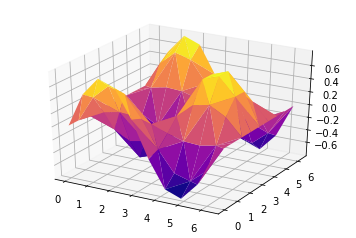

In [26]:
from mpl_toolkits.mplot3d import Axes3D
# Make a new dataset
n= 10
x = np.linspace(0, 2 * np.pi, n)
y = np.linspace(0, 2 * np.pi, n)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) * np.cos(Y)
test_xy = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten()})
test_z = pd.DataFrame({'z': Z.flatten()})

# Prediction
test_z = np.array([prediction(i) for i in test_xy.as_matrix()]).flatten()
#test_yerr = np.array([covariance(i) for i in test_x]).ravel()
#plt.fill_between(test_x, test_y - test_yerr, test_y + test_yerr, facecolor='b', alpha=0.1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(test_xy['x'], test_xy['y'], test_z, cmap='plasma')